<div style="font-size:37px; font-weight:bold; line-height:1.1">
    Geostatistics: Sequential Gaussian Simulation
</div>

<p style="color:rgb(90,90,90);">
The MIT License (MIT)
<br>
Copyright (c) 2018 Massachusetts Institute of Technology
</p>
<p style="color:rgb(90,90,90);">
Author: Guillaume Rongier
<br>
We acknowledge support from NSF ACI1442997 (PI: V. Pankratius) and NASA AISTNNX15AG84G (PI: V. Pankratius).
</p>
<p style="color:rgb(90,90,90);">
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
</p>
<ul style="color:rgb(90,90,90);">
<li>The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.</li>
<li>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</li>
</ul>

This notebook illustrates the use of [Sequential Gaussian Simulation](http://petrowiki.org/Geostatistical_conditional_simulation#Sequential_simulation) (SGS), a geostatistical method for stochastic simulation.

The SGS consists in visiting the nodes of a grid sequentially, and for each node to determine its value based on prior information. Such information is provided by a [variogram](http://petrowiki.org/Spatial_statistics#Semivariograms_and_covariance). A variogram measures how dissimilar are two points separated by a given distance. Thus, it measures the spatial structure that the simulated variable should follow.

The SGS is a classical approach in the petroleum industry to model the properties of the subsurface and their heterogeneity while assessing the uncertainties.

# Package imports

If you rely on Openblas to solve linear systems with NumPy, you should consider using the following set_env. Openblas has multithreading capabilities that dramaticaly slow down the SGS when the neighborhood (so the system to solve) is small

In [ ]:
%set_env OPENBLAS_NUM_THREADS = 1

In [1]:
%matplotlib notebook

import math
import numpy as np
import random
from enum import Enum
import numba.config
from numba import jit
from scipy import stats

import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, FloatRangeSlider

from pyinsar.processing.machine_learning.geostatistics.sequential_gaussian_simulation import *
from pyinsar.processing.machine_learning.geostatistics.variogram import *
from pyinsar.output.plot_raster import *

# Setting

In [2]:
numba.config.NUMBA_NUM_THREADS = 4

The main assumptions of our SGS implementation are that the domain is two-dimensional, that the Euclidean distance is a valid measure of distance over the simulation grid, and that all the grid nodes are equally spaced (however, the spacing can differ depending on the axis).

In [3]:
master_width = 100
master_height = 100

master_x_min = -20. # km
master_x_max = 20. # km
master_y_min = -20. # km
master_y_max = 20. # km

master_extent = (master_x_min, master_x_max, master_y_min, master_y_max) # km

grid_yx_spacing = ((master_y_max - master_y_min)/master_height,
                   (master_x_max - master_x_min)/master_width)

We define a mask, corresponding to areas of the grid where we won't simulate any value.

In [4]:
mask_array = np.ones((master_height, master_width))
mask_array[int(master_height/2 - 25):int(master_height/2 + 25),
           int(master_width/2 - 10):int(master_width/2 + 10)] = 0

# Sequential Gaussian Simulation

We start by simulating two realizations, each with different variograms.

In [5]:
%%time

data_array = np.full((master_height, master_width), -99999.)
data_array[mask_array == 0] = math.nan

vario_models = (VariogramModel.NUGGET, VariogramModel.GAUSSIAN)
vario_sills = (0.0001, 1.)
vario_azimuth = 145
vario_ranges = ((0., 0.), (80., 20.))

seed = 101

secondary_data_1_array = run_sgs(data_array,
                                 grid_yx_spacing,
                                 vario_models,
                                 vario_sills,
                                 vario_azimuth,
                                 vario_ranges,
                                 seed = seed)

CPU times: user 8.67 s, sys: 165 ms, total: 8.84 s
Wall time: 9.74 s


In [6]:
%%time

vario_models = (VariogramModel.SPHERICAL,)
vario_sills = (1.,)
vario_azimuth = 98
vario_ranges = ((100., 10.),)

seed = 102

secondary_data_2_array = run_sgs(data_array,
                                 grid_yx_spacing,
                                 vario_models,
                                 vario_sills,
                                 vario_azimuth,
                                 vario_ranges,
                                 seed = seed)

CPU times: user 2.36 s, sys: 32.2 ms, total: 2.39 s
Wall time: 2.47 s


In [7]:
secondary_data_array = np.array([secondary_data_1_array[0], secondary_data_2_array[0]])

<IPython.core.display.Javascript object>


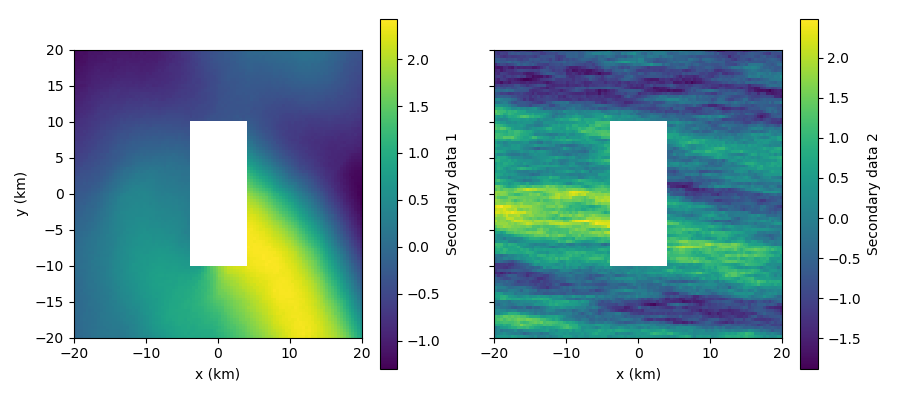

In [8]:
figure, subplots = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (9, 4))

raster_map = subplots[0].imshow(np.ma.masked_invalid(secondary_data_array[0]), extent = master_extent,
                                cmap='viridis', interpolation = 'None', rasterized = True,
                                zorder = 0)
raster_map_colorbar = plt.colorbar(raster_map, ax = subplots[0])
raster_map_colorbar.set_label('Secondary data 1')
subplots[0].set_xlabel('x (km)')
subplots[0].set_ylabel('y (km)')

raster_map = subplots[1].imshow(np.ma.masked_invalid(secondary_data_array[1]), extent = master_extent,
                                cmap='viridis', interpolation = 'None', rasterized = True,
                                zorder = 0)
raster_map_colorbar = plt.colorbar(raster_map, ax = subplots[1])
raster_map_colorbar.set_label('Secondary data 2')
subplots[1].set_xlabel('x (km)')

plt.tight_layout()
                
plt.show()

Now, we combine those two realizations into a single variable. This variable will then be used as secondary data to influence the simulation of other realizations. Merging the secondary data and their weights beforehands makes the simulation process easier. This procedure relies on the work of [Babak and Deutsch (2009)](https:/doi.org/10.1016/j.petrol.2009.08.001).

In [9]:
correlations_with_primary = np.ones((secondary_data_array.shape[0]))
correlations_with_primary[0] = 0.75
correlations_with_primary[1] = 0.35

correlations_between_secondary = np.ones((secondary_data_array.shape[0], secondary_data_array.shape[0]))
correlations_between_secondary[0, 1] = 0.1
correlations_between_secondary[1, 0] = correlations_between_secondary[0, 1]

In [10]:
merged_secondary_data_array, merged_secondary_data_weight = merge_secondary_data(secondary_data_array,
                                                                                 correlations_with_primary,
                                                                                 correlations_between_secondary)

<IPython.core.display.Javascript object>


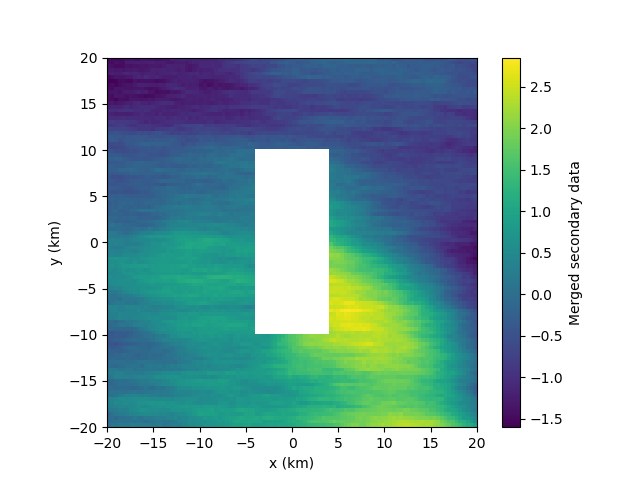

In [11]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

raster_map = plt.imshow(np.ma.masked_invalid(merged_secondary_data_array), extent = master_extent,
                        cmap='viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)

raster_map_colorbar = plt.colorbar(raster_map)
raster_map_colorbar.set_label('Merged secondary data')

subfigure.set_xlabel('x (km)')
subfigure.set_ylabel('y (km)')
                
plt.show()

Finally, we can simulate two realizations using the same variogram and the previously merged secondary data. The SGS relies on an intrinsic collocated cokriging to simulate a value for each cell while taking into account the secondary data. This kriging method was developed by [Babak and Deutsch (2009)](https:/doi.org/10.1016/j.cageo.2008.02.025).

In [12]:
%%time

data_array = np.full((master_height, master_width), -99999.)
data_array[mask_array == 0] = math.nan

vario_models = (VariogramModel.NUGGET, VariogramModel.GAUSSIAN)
vario_sills = (0.0001, 1.)
vario_azimuth = 0.
vario_ranges = ((0., 0.), (5., 5.))
max_number_data = 20

number_realizations = 2
seed = 100

simulation_array = run_sgs(data_array,
                           grid_yx_spacing,
                           vario_models,
                           vario_sills,
                           vario_azimuth,
                           vario_ranges,
                           number_realizations,
                           max_number_data = max_number_data,
                           secondary_data_weight = merged_secondary_data_weight,
                           secondary_data_array = merged_secondary_data_array,
                           seed = seed)

CPU times: user 2.02 s, sys: 24.2 ms, total: 2.05 s
Wall time: 2.11 s


<IPython.core.display.Javascript object>


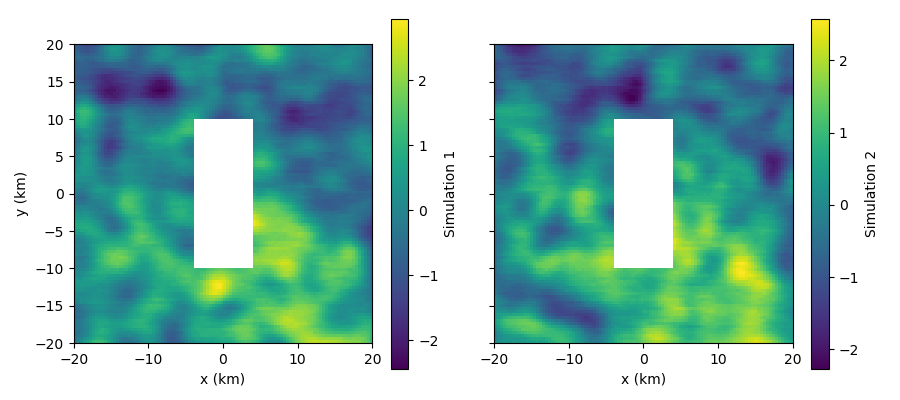

In [13]:
figure, subplots = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (9, 4))

raster_map = subplots[0].imshow(np.ma.masked_invalid(simulation_array[0]), extent = master_extent,
                                cmap='viridis', interpolation = 'None', rasterized = True,
                                zorder = 0)
raster_map_colorbar = plt.colorbar(raster_map, ax = subplots[0])
raster_map_colorbar.set_label('Simulation 1')
subplots[0].set_xlabel('x (km)')
subplots[0].set_ylabel('y (km)')

raster_map = subplots[1].imshow(np.ma.masked_invalid(simulation_array[1]), extent = master_extent,
                                cmap='viridis', interpolation = 'None', rasterized = True,
                                zorder = 0)
raster_map_colorbar = plt.colorbar(raster_map, ax = subplots[1])
raster_map_colorbar.set_label('Simulation 2')
subplots[1].set_xlabel('x (km)')

plt.tight_layout()
                
plt.show()

# Interactive Sequential Gaussian Simulation

We can define some interactive widgets thanks to Jupyter to play around with the SGS' parameters, and see their impact on the simulation results.

In [14]:
def interactive_sgs(variogram_model,
                    nugget,
                    azimuth,
                    ranges,
                    max_number_data,
                    neighborhood,
                    secondary_data_weight,
                    seed):
    
    vario_models = (VariogramModel.NUGGET, variogram_model,)
    if variogram_model == VariogramModel.NUGGET:
        nugget = 0.
    vario_sills = (nugget, 1.,)
    vario_azimuth = azimuth
    vario_ranges = ((0., 0.), (ranges[1], ranges[0]),)
    neighborhood_range = (neighborhood[1], neighborhood[0])
    simulation_array = run_sgs(data_array,
                               grid_yx_spacing,
                               vario_models,
                               vario_sills,
                               vario_azimuth,
                               vario_ranges,
                               1,
                               neighborhood_range = neighborhood_range,
                               max_number_data = max_number_data,
                               secondary_data_weight = secondary_data_weight,
                               secondary_data_array = secondary_data_array[0],
                               seed = seed)
    simulation_map.set_data(simulation_array[0])
    
    variogram_array = map_2D_variogram(vario_models,
                                       vario_sills,
                                       vario_azimuth,
                                       vario_ranges,
                                       neighborhood_range,
                                       simulation_array[0].shape,
                                       grid_yx_spacing)
    variogram_map.set_data(variogram_array)
    
    deltas_x = np.zeros((100))
    deltas_y = np.linspace(0.0001, neighborhood_range[0], 100)
    variogram_range_1 = compute_range_variogram(deltas_y, deltas_x, vario_models, vario_sills, vario_ranges)
    variogram_plot_1.set_data(deltas_y, variogram_range_1)
    
    deltas_y = np.linspace(0.0001, neighborhood_range[1], 100)
    variogram_range_2 = compute_range_variogram(deltas_x, deltas_y, vario_models, vario_sills, vario_ranges)
    variogram_plot_2.set_data(deltas_y, variogram_range_2)
    
    plt.draw()

<IPython.core.display.Javascript object>


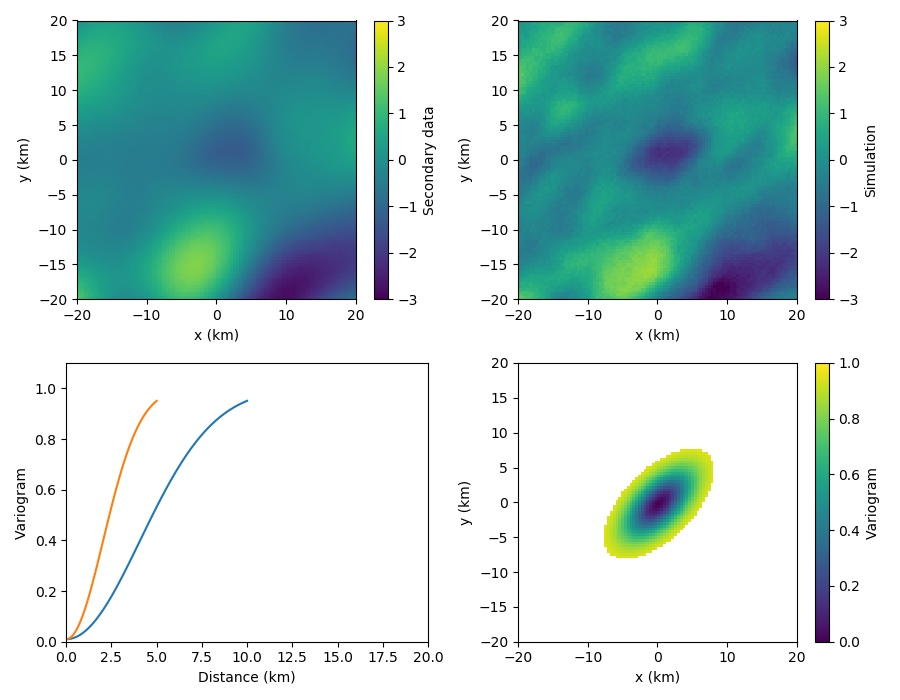

interactive(children=(Dropdown(description='Variogram model', options=(('Gaussian', <VariogramModel.GAUSSIAN: 1>), ('Spherical', <VariogramModel.SPHERICAL: 2>), ('Exponential', <VariogramModel.EXPONENTIAL: 3>), ('Nugget', <VariogramModel.NUGGET: 0>)), value=<VariogramModel.GAUSSIAN: 1>), FloatSlider(value=0.01, continuous_update=False, description='Nugget', max=1.0, step=0.01), FloatSlider(value=45.0, continuous_update=False, description='Azimuth (degree)', max=360.0, step=5.0), FloatRangeSlider(value=(5.0, 10.0), continuous_update=False, description='Ranges (km)', max=40.0, min=1.0, step=1.0), FloatSlider(value=20.0, continuous_update=False, description='Maximum number of data', step=5.0), FloatRangeSlider(value=(5.0, 10.0), continuous_update=False, description='Neighborhood', max=40.0, min=1.0, step=1.0), FloatSlider(value=0.9, continuous_update=False, description='Secondary data weight', max=0.96, min=-0.95, step=0.05), IntSlider(value=100, continuous_update=False, description='Seed', max=1000, step=10), Output()), _dom_classes=('widget-interact',))

In [15]:
data_array = np.full((master_height, master_width), -99999.)

vario_models = (VariogramModel.NUGGET, VariogramModel.GAUSSIAN,)
vario_sills = (0.0001, 1.,)
vario_azimuth = 45
vario_ranges = ((0., 0.), (25., 15.),)
max_number_data = 20
number_realizations = 1
seed = 100
secondary_data_array = run_sgs(data_array,
                               grid_yx_spacing,
                               vario_models,
                               vario_sills,
                               vario_azimuth,
                               vario_ranges,
                               number_realizations,
                               max_number_data = max_number_data,
                               seed = seed)

deltas_y = np.arange(0., 20., 0.1)
deltas_x = np.zeros((len(deltas_y)))
variogram_range_1 = compute_range_variogram(deltas_y, deltas_x, vario_models, vario_sills, vario_ranges)
    
figure, subplots = plt.subplots(2, 2, figsize = (9, 7)) # , sharex = True, sharey = True

secondary_data_map = subplots[0, 0].imshow(np.ma.masked_invalid(secondary_data_array[0]),
                                     vmin = -3, vmax = 3, extent = master_extent,
                                     cmap = 'viridis', interpolation = 'None', rasterized = True,
                                     zorder = 0)
secondary_data_colorbar = plt.colorbar(secondary_data_map, ax = subplots[0, 0])
secondary_data_colorbar.set_label('Secondary data')
subplots[0, 0].set_xlabel('x (km)')
subplots[0, 0].set_ylabel('y (km)')

simulation_map = subplots[0, 1].imshow(np.ma.masked_invalid(secondary_data_array[0]),
                                 vmin = -3, vmax = 3, extent = master_extent,
                                 cmap = 'viridis', interpolation = 'None', rasterized = True,
                                 zorder = 0)
simulation_colorbar = plt.colorbar(simulation_map, ax = subplots[0, 1])
simulation_colorbar.set_label('Simulation')
subplots[0, 1].set_xlabel('x (km)')
subplots[0, 1].set_ylabel('y (km)')

variogram_map = subplots[1, 1].imshow(np.ma.masked_invalid(secondary_data_array[0]),
                                 vmin = 0., vmax = 1., extent = master_extent,
                                 cmap = 'viridis', interpolation = 'None', rasterized = True,
                                 zorder = 0)
variogram_colorbar = plt.colorbar(variogram_map, ax = subplots[1, 1])
variogram_colorbar.set_label('Variogram')
subplots[1, 1].set_xlabel('x (km)')
subplots[1, 1].set_ylabel('y (km)')

variogram_plot_1, = subplots[1, 0].plot(deltas_y, variogram_range_1)
variogram_plot_2, = subplots[1, 0].plot(deltas_y, variogram_range_1)
subplots[1, 0].set_xlim([0., master_x_max])
subplots[1, 0].set_ylim([0., 1.1])
subplots[1, 0].set_xlabel('Distance (km)')
subplots[1, 0].set_ylabel('Variogram')

plt.tight_layout()

plt.show()

interactive_plot = interact(interactive_sgs,
                            variogram_model = Dropdown(options = (('Gaussian', VariogramModel.GAUSSIAN),
                                                                  ('Spherical', VariogramModel.SPHERICAL),
                                                                  ('Exponential', VariogramModel.EXPONENTIAL),
                                                                  ('Nugget', VariogramModel.NUGGET)), value = VariogramModel.GAUSSIAN, description = 'Variogram model', continuous_update = False),
                            nugget = FloatSlider(value = 0.01, min = 0., max = 1., step = 0.01, description = 'Nugget', continuous_update = False),
                            azimuth = FloatSlider(value = 45., min = 0., max = 360., step = 5., description = 'Azimuth (degree)', continuous_update = False),
                            ranges = FloatRangeSlider(value = [5., 10.], min = 1., max = 40., step = 1., description = 'Ranges (km)', continuous_update = False),
                            max_number_data = FloatSlider(value = 20., min = 0., max = 100., step = 5., description = 'Maximum number of data', continuous_update = False),
                            neighborhood = FloatRangeSlider(value = [5., 10.], min = 1., max = 40., step = 1., description = 'Neighborhood', continuous_update = False),
                            secondary_data_weight = FloatSlider(value = 0.9, min = -0.95, max = 0.96, step = 0.05, description = 'Secondary data weight', continuous_update = False),
                            seed = IntSlider(value = 100, min = 0, max = 1000, step = 10, description = 'Seed', continuous_update = False))

# Normal-score transform

The SGS assumes that the simulated variable is normally distributed. When using input data, we need to transform them to a normal distribution. And after the simulation, we need to transform the realizations to the wanted distribution. One way to do that is through the [normal-score tranform](http://petrowiki.org/Statistical_concepts#Normal_score_transform) and its back-transform.

In [16]:
%%time

normalized_simulation_array = normal_score_tranform(simulation_array[0])

CPU times: user 767 ms, sys: 9.07 ms, total: 776 ms
Wall time: 792 ms


<IPython.core.display.Javascript object>


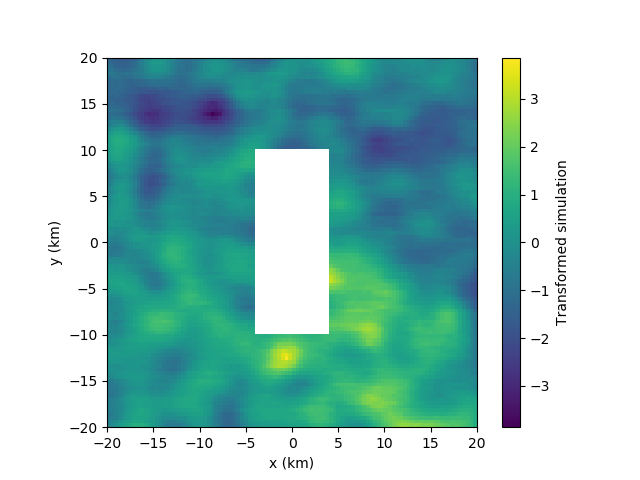

In [17]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

raster_map = plt.imshow(np.ma.masked_invalid(normalized_simulation_array), extent = master_extent,
                        cmap='viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)
# plt.contour(area_xx_array, area_yy_array, simulation_array[0], 20, colors = 'black', linewidths = 0.5)

raster_map_colorbar = plt.colorbar(raster_map)
raster_map_colorbar.set_label('Transformed simulation')

subfigure.set_xlabel('x (km)')
subfigure.set_ylabel('y (km)')
                
plt.show()

In [18]:
%%time

cumulative_frequency_array = compute_averaged_cumulative_distribution_from_array(simulation_array[0])
transformed_simulation_array = stats.uniform.ppf(cumulative_frequency_array, loc = 2, scale = 10)

CPU times: user 8.07 ms, sys: 3.95 ms, total: 12 ms
Wall time: 36.2 ms


/Users/grongier/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in greater
  cond1 = (0 < q) & (q < 1)
/Users/grongier/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1904: RuntimeWarning: invalid value encountered in less
  cond1 = (0 < q) & (q < 1)


<IPython.core.display.Javascript object>


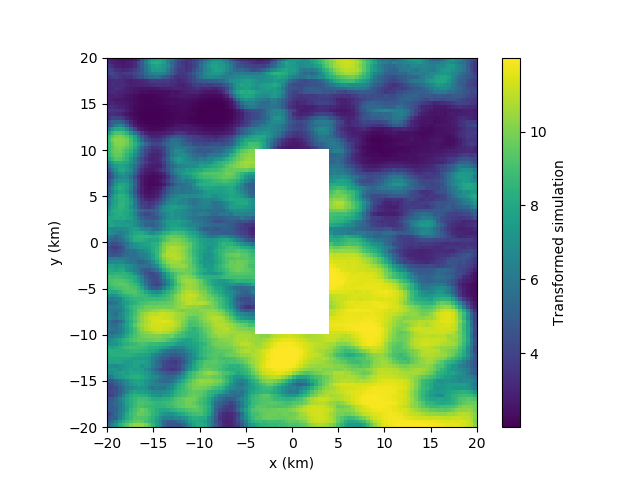

In [19]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

raster_map = plt.imshow(np.ma.masked_invalid(transformed_simulation_array), extent = master_extent,
                        cmap='viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)
# plt.contour(area_xx_array, area_yy_array, simulation_array[0], 20, colors = 'black', linewidths = 0.5)

raster_map_colorbar = plt.colorbar(raster_map)
raster_map_colorbar.set_label('Transformed simulation')

subfigure.set_xlabel('x (km)')
subfigure.set_ylabel('y (km)')
                
plt.show()

<IPython.core.display.Javascript object>


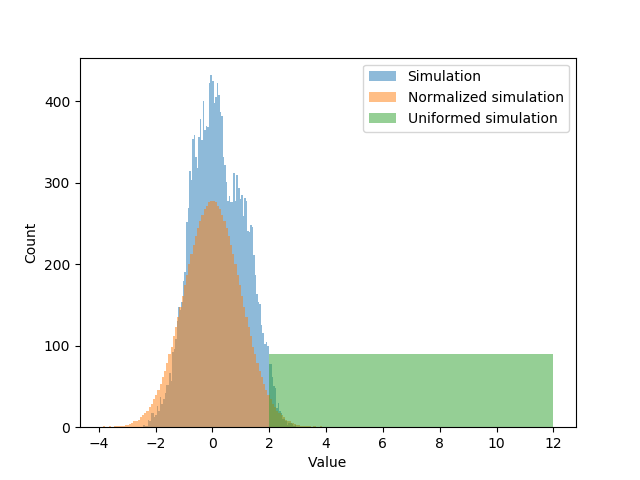

In [20]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

handles = []
colors = ['blue', 'green', 'magenta', 'cyan']

plt.hist(simulation_array[~np.isnan(simulation_array)].ravel(), label = 'Simulation', bins = 100, alpha = 0.5)
plt.hist(normalized_simulation_array[~np.isnan(normalized_simulation_array)].ravel(), label = 'Normalized simulation', bins = 100, alpha = 0.5)
plt.hist(transformed_simulation_array[~np.isnan(transformed_simulation_array)].ravel(), label = 'Uniformed simulation', bins = 100, alpha = 0.5)

plt.legend()

subfigure.set_xlabel('Value')
subfigure.set_ylabel('Count')
                
plt.show()

# Parallel SGS

Due to the sequential nature of the SGS, paralleizing the algorithm is difficult. But Simulating several realizations is an embarrassingly parallel problem, because each realizations is independant from the others.

In [21]:
%%time

data_array = np.full((master_height, master_width), -99999.)

vario_models = (VariogramModel.NUGGET, VariogramModel.GAUSSIAN)
vario_sills = (0.0001, 1.)
vario_azimuth = 145
vario_ranges = ((0., 0.), (20., 10.))

number_realizations = 1000

seed = 101

simulation_array = run_parallel_sgs(data_array,
                                    grid_yx_spacing,
                                    vario_models,
                                    vario_sills,
                                    vario_azimuth,
                                    vario_ranges,
                                    number_realizations = number_realizations,
                                    seed = seed)

CPU times: user 1min 51s, sys: 1.01 s, total: 1min 52s
Wall time: 40.8 s


<IPython.core.display.Javascript object>


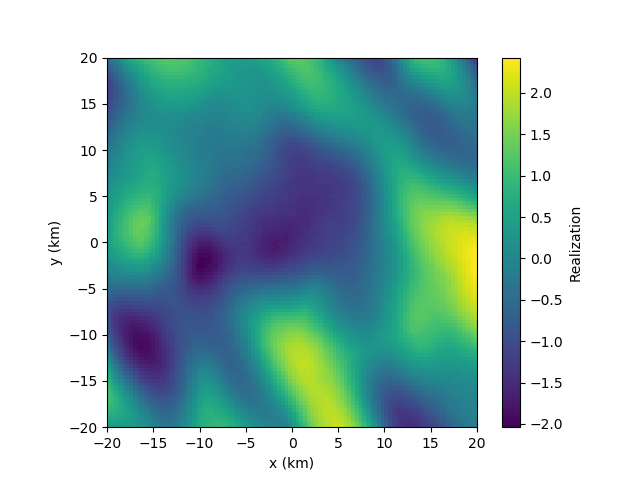

interactive(children=(BoundedIntText(value=0, description='Slice', max=999), Output()), _dom_classes=('widget-interact',))

In [22]:
plot_interactive_slicing(simulation_array,
                         0,
                         extent = master_extent,
                         clabel = 'Realization', 
                         xlabel = 'x (km)',
                         ylabel = 'y (km)')